# Performance Python

**REMARK**: This notebook has been changed to Python **3.4**; needs a cluster to be running under 'default' profile for the IPython.parallel example.

In [1]:
def perf_comp_data(func_list, data_list, rep=3, number=1):
    ''' Function to compare the performance of different functions.
    
    Parameters
    ==========
    func_list : list
        list with function names as strings
    data_list : list
        list with data set names as strings
    rep : int
        number of repetitions of the whole comparison
    number : int
        number of executions for every function
    '''
    from timeit import repeat
    res_list = {}
    for name in enumerate(func_list):
        stmt = name[1] + '(' + data_list[name[0]] + ')'
        setup = "from __main__ import " + name[1] + ', ' \
                                    + data_list[name[0]]
        results = repeat(stmt=stmt, setup=setup,
                         repeat=rep, number=number)
        res_list[name[1]] = sum(results) / rep
    res_sort = sorted(res_list.items(),
                      key=lambda x: (x[1], x[0]))
    for item in res_sort:
        rel = item[1] / res_sort[0][1]
        print ('function: ' + item[0] +
              ', av. time sec: %9.5f, ' % item[1]
            + 'relative: %6.1f' % rel)

## Python Paradigms and Performance

In [2]:
from math import *
def f(x):
    return abs(cos(x)) ** 0.5 + sin(2 + 3 * x)

In [3]:
#I = 500000
I = 10000
a_py = range(I)

In [4]:
def f1(a):
    res = []
    for x in a:
        res.append(f(x))
    return res

In [5]:
def f2(a):
    return [f(x) for x in a]

In [6]:
def f3(a):
    ex = 'abs(cos(x)) ** 0.5 + sin(2 + 3 * x)'
    return [eval(ex) for x in a]

In [7]:
import numpy as np

In [8]:
a_np = np.arange(I)

In [9]:
def f4(a):
    return (np.abs(np.cos(a)) ** 0.5 +
            np.sin(2 + 3 * a))

In [10]:
import numexpr as ne

In [11]:
def f5(a):
    ex = 'abs(cos(a)) ** 0.5 + sin(2 + 3 * a)'
    ne.set_num_threads(1)
    return ne.evaluate(ex)

In [12]:
def f6(a):
    ex = 'abs(cos(a)) ** 0.5 + sin(2 + 3 * a)'
    ne.set_num_threads(16)
    return ne.evaluate(ex)

In [13]:
%%time
r1 = f1(a_py)
r2 = f2(a_py)
r3 = f3(a_py)
r4 = f4(a_np)
r5 = f5(a_np)
r6 = f6(a_np)

Wall time: 214 ms


In [14]:
np.allclose(r1, r2)

True

In [15]:
np.allclose(r1, r3)

True

In [16]:
np.allclose(r1, r4)

True

In [17]:
np.allclose(r1, r5)

True

In [18]:
np.allclose(r1, r6)

True

In [19]:
func_list = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
data_list = ['a_py', 'a_py', 'a_py', 'a_np', 'a_np', 'a_np']

In [20]:
perf_comp_data(func_list, data_list)

function: f4, av. time sec:   0.00045, relative:    1.0
function: f5, av. time sec:   0.00072, relative:    1.6
function: f6, av. time sec:   0.00114, relative:    2.6
function: f2, av. time sec:   0.01253, relative:   28.1
function: f1, av. time sec:   0.01852, relative:   41.6
function: f3, av. time sec:   0.15863, relative:  356.1


## Memory Layout and Performance

In [21]:
import numpy as np

In [22]:
np.zeros((3, 3), dtype=np.float64, order='C')

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [23]:
c = np.array([[ 1.,  1.,  1.],
              [ 2.,  2.,  2.],
              [ 3.,  3.,  3.]], order='C')

In [24]:
f = np.array([[ 1.,  1.,  1.],
              [ 2.,  2.,  2.],
              [ 3.,  3.,  3.]], order='F')

In [25]:
#x = np.random.standard_normal((3, 150000))
x = np.random.standard_normal((3, 15000))
C = np.array(x, order='C')
F = np.array(x, order='F')
x = 0.0

In [26]:
%timeit C.sum(axis=0)

The slowest run took 8.15 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 28.8 µs per loop


In [27]:
%timeit C.sum(axis=1)

10000 loops, best of 3: 26.5 µs per loop


In [28]:
%timeit C.std(axis=0)

1000 loops, best of 3: 234 µs per loop


In [29]:
%timeit C.std(axis=1)

10000 loops, best of 3: 115 µs per loop


In [30]:
%timeit F.sum(axis=0)

10000 loops, best of 3: 193 µs per loop


In [31]:
%timeit F.sum(axis=1)

1000 loops, best of 3: 269 µs per loop


In [32]:
%timeit F.std(axis=0)

1000 loops, best of 3: 745 µs per loop


In [33]:
%timeit F.std(axis=1)

1000 loops, best of 3: 706 µs per loop


In [34]:
C = 0.0; F = 0.0

## Parallel Computing

### The Monte Carlo Algorithm

In [35]:
def bsm_mcs_valuation(strike):
    ''' Dynamic Black-Scholes-Merton Monte Carlo estimator
    for European calls.
    
    Parameters
    ==========
    strike : float
        strike price of the option
    
    Results
    =======
    value : float
        estimate for present value of call option
    '''
    import numpy as np
    S0 = 100.; T = 1.0; r = 0.05; vola = 0.2
    M = 50; I = 20000
    dt = T / M
    rand = np.random.standard_normal((M + 1, I))
    S = np.zeros((M + 1, I)); S[0] = S0
    for t in range(1, M + 1):
        S[t] = S[t-1] * np.exp((r - 0.5 * vola ** 2) * dt
                               + vola * np.sqrt(dt) * rand[t])
    value = (np.exp(-r * T)
                     * np.sum(np.maximum(S[-1] - strike, 0)) / I)
    return value

### The Sequential Calculation

In [36]:
def seq_value(n):
    ''' Sequential option valuation.
    
    Parameters
    ==========
    n : int
        number of option valuations/strikes
    '''
    strikes = np.linspace(80, 120, n)
    option_values = []
    for strike in strikes:
        option_values.append(bsm_mcs_valuation(strike))
    return strikes, option_values

In [37]:
n = 100  # number of options to be valued
%time strikes, option_values_seq = seq_value(n)

Wall time: 5.56 s


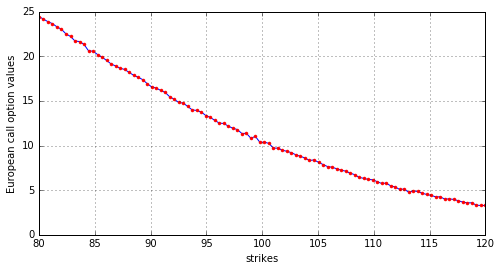

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.plot(strikes, option_values_seq, 'b')
plt.plot(strikes, option_values_seq, 'r.')
plt.grid(True)
plt.xlabel('strikes')
plt.ylabel('European call option values')
# tag: option_values
# title: European call option values by Monte Carlo simulation
# size: 60

### The Parallel Calculation

In [39]:
#  conda install ipyparallel
from IPython.parallel import Client
#from ipyparallel import Client

d:\Anaconda2\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [40]:
c = Client(profile="default")
view = c.load_balanced_view()

Waiting for connection file: ~\.ipython\profile_default\security\ipcontroller-client.json


IOError: Connection file '~\\.ipython\\profile_default\\security\\ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [41]:
def par_value(n):
    ''' Sequential option valuation.
    
    Parameters
    ==========
    n : int
        number of option valuations/strikes
    '''
    strikes = np.linspace(80, 120, n)
    option_values = []
    for strike in strikes:
        value = view.apply_async(bsm_mcs_valuation, strike)
        option_values.append(value)
    c.wait(option_values)
    return strikes, option_values

In [42]:
%time strikes, option_values_obj = par_value(n)

NameError: global name 'view' is not defined

In [43]:
option_values_obj[0].metadata

NameError: name 'option_values_obj' is not defined

In [44]:
option_values_obj[0].result

NameError: name 'option_values_obj' is not defined

In [45]:
option_values_par = []
for res in option_values_obj:
    option_values_par.append(res.result)

NameError: name 'option_values_obj' is not defined

ValueError: x and y must have same first dimension

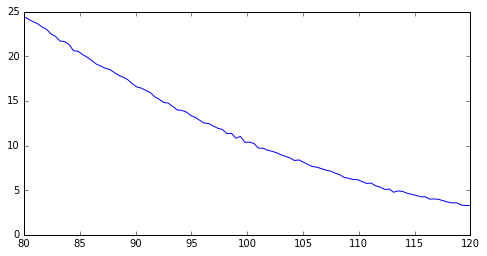

In [46]:
plt.figure(figsize=(8, 4))
plt.plot(strikes, option_values_seq, 'b', label='Sequential')
plt.plot(strikes, option_values_par, 'r.', label='Parallel')
plt.grid(True); plt.legend(loc=0)
plt.xlabel('strikes')
plt.ylabel('European call option values')
# tag: option_comp
# title: Comparison of European call option values
# size: 60

### Performance Comparison

In [47]:
n = 50  # number of option valuations
func_list = ['seq_value', 'par_value']
data_list = 2 * ['n']

In [48]:
perf_comp_data(func_list, data_list)

NameError: global name 'view' is not defined

## Multiprocessing

In [57]:
import multiprocessing as mp

In [58]:
import math
def simulate_geometric_brownian_motion(p):
    M, I = p
      # time steps, paths
    S0 = 100; r = 0.05; sigma = 0.2; T = 1.0
      # model parameters
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                    sigma * math.sqrt(dt) * np.random.standard_normal(I))
    return paths

In [59]:
paths = simulate_geometric_brownian_motion((5, 2))
paths

array([[ 100.        ,  100.        ],
       [  97.23136564,  105.40054508],
       [ 100.8343703 ,   97.97723044],
       [  93.01098166,  115.40199426],
       [  80.70701837,  128.26898108],
       [  75.09617303,  126.70780456]])

In [60]:
#I = 10000  # number of paths
I = 1000  # number of paths
M = 50  # number of time steps
t = 20  # number of tasks/simulations

In [ ]:
# running on server with 4 cores
from time import time
times = []
for w in range(1, 5):
    t0 = time()
    pool = mp.Pool(processes=w)
      # the pool of workers
    result = pool.map(simulate_geometric_brownian_motion, t * [(M, I), ])
      # the mapping of the function to the list of parameter tuples
    times.append(time() - t0)

In [ ]:
plt.plot(range(1, 5), times)
plt.plot(range(1, 5), times, 'ro')
plt.grid(True)
plt.xlabel('number of processes')
plt.ylabel('time in seconds')
plt.title('%d Monte Carlo simulations' % t)
# tag: multi_proc
# title: Comparison execution speed dependent on the number of threads used (4 core machine)
# size: 60

## Dynamic Compiling

### Introductory Example

In [ ]:
from math import cos, log
def f_py(I, J):
    res = 0
    for i in range(I):
        for j in range (J):
            res += int(cos(log(1)))
    return res

In [ ]:
I, J = 2500, 2500
%time f_py(I, J)

In [ ]:
def f_np(I, J):
    a = np.ones((I, J), dtype=np.float64)
    return int(np.sum(np.cos(np.log(a)))), a

In [ ]:
%time res, a = f_np(I, J)

In [ ]:
a.nbytes

In [ ]:
import numba as nb

In [ ]:
f_nb = nb.jit(f_py)

In [ ]:
%time f_nb(I, J)

In [ ]:
func_list = ['f_py', 'f_np', 'f_nb']
data_list = 3 * ['I, J']

In [ ]:
perf_comp_data(func_list, data_list)

### Binomial Option Pricing

In [ ]:
# model & option Parameters
S0 = 100.  # initial index level
T = 1.  # call option maturity
r = 0.05  # constant short rate
vola = 0.20  # constant volatility factor of diffusion

# time parameters
M = 1000  # time steps
dt = T / M  # length of time interval
df = exp(-r * dt)  # discount factor per time interval

# binomial parameters
u = exp(vola * sqrt(dt))  # up-movement
d = 1 / u  # down-movement
q = (exp(r * dt) - d) / (u - d)  # martingale probability

In [ ]:
import numpy as np
def binomial_py(strike):
    ''' Binomial option pricing via looping.
    
    Parameters
    ==========
    strike : float
        strike price of the European call option
    '''
    # LOOP 1 - Index Levels
    S = np.zeros((M + 1, M + 1), dtype=np.float64)
      # index level array
    S[0, 0] = S0
    z1 = 0
    for j in range(1, M + 1, 1):
        z1 = z1 + 1
        for i in range(z1 + 1):
            S[i, j] = S[0, 0] * (u ** j) * (d ** (i * 2))
            
    # LOOP 2 - Inner Values
    iv = np.zeros((M + 1, M + 1), dtype=np.float64)
      # inner value array
    z2 = 0
    for j in range(0, M + 1, 1):
        for i in range(z2 + 1):
            iv[i, j] = max(S[i, j] - strike, 0)
        z2 = z2 + 1
        
    # LOOP 3 - Valuation
    pv = np.zeros((M + 1, M + 1), dtype=np.float64)
      # present value array
    pv[:, M] = iv[:, M]  # initialize last time point
    z3 = M + 1
    for j in range(M - 1, -1, -1):
        z3 = z3 - 1
        for i in range(z3):
            pv[i, j] = (q * pv[i, j + 1] +
                        (1 - q) * pv[i + 1, j + 1]) * df
    return pv[0, 0]

In [ ]:
%time round(binomial_py(100), 3)

In [ ]:
%time round(bsm_mcs_valuation(100), 3)

In [ ]:
def binomial_np(strike):
    ''' Binomial option pricing with NumPy.
    
    Parameters
    ==========
    strike : float
        strike price of the European call option
    '''
    # Index Levels with NumPy
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    mu = u ** (mu - md)
    md = d ** md
    S = S0 * mu * md
    
    # Valuation Loop
    pv = np.maximum(S - strike, 0)

    z = 0
    for t in range(M - 1, -1, -1):  # backwards iteration
        pv[0:M - z, t] = (q * pv[0:M - z, t + 1]
                        + (1 - q) * pv[1:M - z + 1, t + 1]) * df
        z += 1
    return pv[0, 0]

In [ ]:
M = 4  # four time steps only
mu = np.arange(M + 1)
mu

In [ ]:
mu = np.resize(mu, (M + 1, M + 1))
mu

In [ ]:
md = np.transpose(mu)
md

In [ ]:
mu = u ** (mu - md)
mu.round(3)

In [ ]:
md = d ** md
md.round(3)

In [ ]:
S = S0 * mu * md
S.round(3)

In [ ]:
M = 1000  # reset number of time steps
%time round(binomial_np(100), 3)

In [ ]:
binomial_nb = nb.jit(binomial_py)

In [49]:
%time round(binomial_nb(100), 3)

NameError: name 'binomial_nb' is not defined

In [50]:
func_list = ['binomial_py', 'binomial_np', 'binomial_nb']
K = 100.
data_list = 3 * ['K']

In [51]:
perf_comp_data(func_list, data_list)

ImportError: cannot import name binomial_py

## Static Compiling with Cython

In [52]:
def f_py(I, J):
    res = 0.  # we work on a float object
    for i in range(I):
        for j in range (J * I):
            res += 1
    return res

In [53]:
I, J = 500, 500
%time f_py(I, J)

Wall time: 8.82 s


125000000.0

In [54]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0xa4e5240>)

In [55]:
import sys
sys.path.append('data/')
  # path to the Cython script
  # not needed if in same directory

In [56]:
from nested_loop import f_cy

ImportError: Building module nested_loop failed: ['DistutilsPlatformError: Unable to find vcvarsall.bat\n']

In [ ]:
%time res = f_cy(I, J)

In [ ]:
res

In [ ]:
%load_ext Cython

In [ ]:
%%cython
#
# Nested loop example with Cython
#
def f_cy(int I, int J):
    cdef double res = 0
    # double float much slower than int or long
    for i in range(I):
        for j in range (J * I):
            res += 1
    return res

In [ ]:
%time res = f_cy(I, J)

In [ ]:
res

In [ ]:
import numba as nb

In [ ]:
f_nb = nb.jit(f_py)

In [ ]:
%time res = f_nb(I, J)

In [ ]:
res

In [ ]:
func_list = ['f_py', 'f_cy', 'f_nb']
I, J = 500, 500
data_list = 3 * ['I, J']

In [ ]:
perf_comp_data(func_list, data_list)

## Generation of Random Numbers on GPUs

## Conclusions

## Further Reading